# Synthetic TCSPC data in a cat image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from scipy.stats import norm
from scipy.signal import convolve

from skimage import io
from skimage.measure import label # regionprops_table
from skimage.morphology import remove_small_objects
from skimage.color import label2rgb

from napari_flim_phasor_plotter import _synthetic as syn
import napari

1. Loading the image

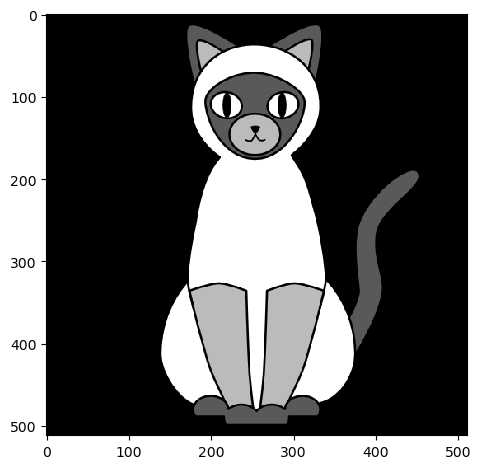

In [2]:
image_path = "../data/medium_thick_cat.tiff"

cat_array = io.imread(image_path)
io.imshow(cat_array, cmap=plt.cm.gray)

In [3]:
from skimage.transform import downscale_local_mean
cat_array_downscaled = cat_array[::2, ::2]
cat_array_downscaled2 = np.around(downscale_local_mean(cat_array, (2, 2)))

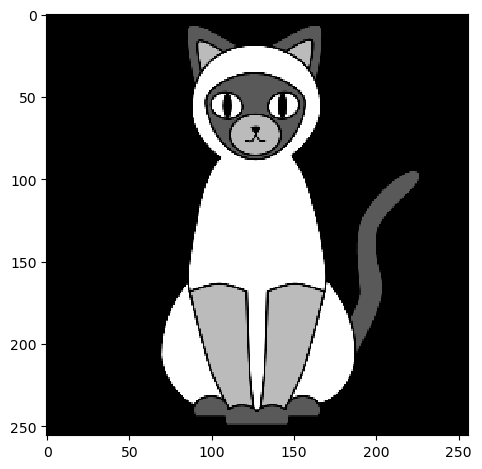

In [4]:
io.imshow(cat_array_downscaled, cmap=plt.cm.gray)

c:\Users\mazo260d\mambaforge\envs\napari-flim-dev\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


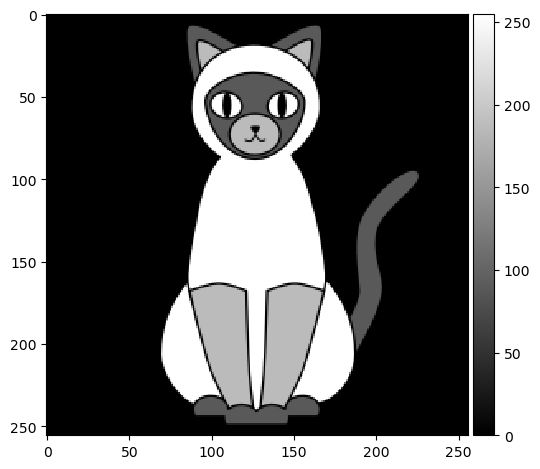

In [5]:
io.imshow(cat_array_downscaled2, cmap=plt.cm.gray)

In [6]:
np.unique(cat_array_downscaled2, return_counts=True)

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
        143., 144., 145., 146., 147., 

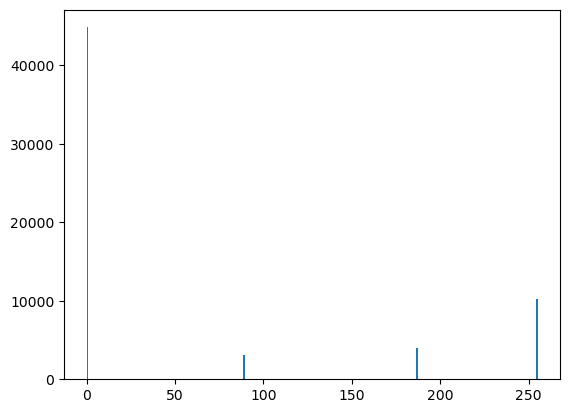

In [7]:
plt.hist(cat_array_downscaled2.ravel(), bins = 256)
plt.show()

Due to some noise in the borders in the png image I divide the image into 4 regions based on the intervals.
* 89 - lifetime tau1
* 187 - mixed lifetimes
* 255 - lifetime tau2
* everything inbetween - background

In [8]:
cat_array = cat_array_downscaled2

copy_cat = np.zeros(cat_array.shape, dtype=np.uint8)
copy_cat[cat_array  == 89] = 1
copy_cat[cat_array == 187] = 2
copy_cat[cat_array == 255 ] = 3

The I created and visualized masks corresponding to four regions:

In [9]:
white = np.zeros(copy_cat.shape, dtype=bool)
white[copy_cat==3] = True

grey = np.zeros(copy_cat.shape, dtype=bool)
grey[copy_cat==2] = True

dark = np.zeros(copy_cat.shape, dtype=bool)
dark[copy_cat==1] = True

black = np.zeros(copy_cat.shape, dtype=bool)
black[copy_cat==0] = True

In [10]:
lifetime_cat_labels = 0 * black.astype('int') +  dark.astype('int') + 2 * grey.astype('int') + 3 * white.astype('int')

In [11]:
# imsave('lifetime_cat_labels.tif', lifetime_cat_labels)

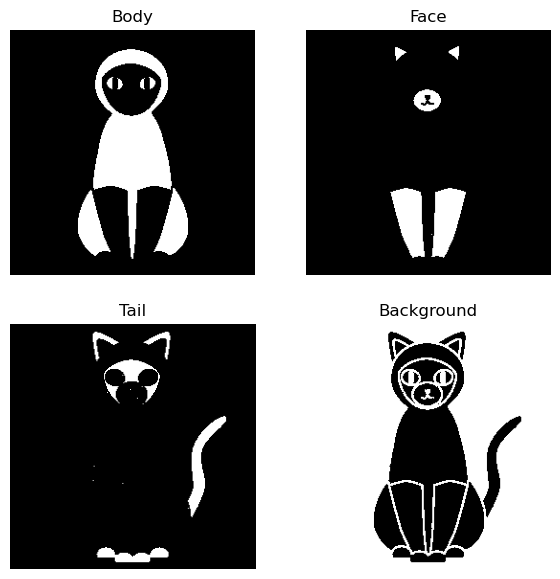

In [12]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 2, 1)
plt.imshow(white, cmap='gray')
plt.title('Body')
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(grey, cmap='gray')
plt.title('Face')
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(dark, cmap='gray')
plt.title("Tail")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(black, cmap='gray')
plt.title("Background")
plt.axis("off")

plt.show()


### Generating synthetic lifetime decays

In [13]:
def calculate_exp(x, A, tau):
    import numpy as np
    if np.isscalar(tau):
        tau = np.array([tau])
        A = np.array([A])
    return np.sum(A[:, None] * np.exp(-1/tau[:, None]*x), axis = 0)

In [14]:
def create_synthetic_decay(number_of_output_time_points, amplitudes, life_times, laser_frequency = 40,
                            max_photon_count = 2000, offset = 0.3, irf_fwhm = 0.1, round_to_int = False):
    import numpy as np
    from scipy.stats import norm
    from scipy.signal import convolve
    from napari_flim_phasor_plotter import _synthetic as syn

    ratio = int(np.rint(10000/number_of_output_time_points))
    number_of_time_points = ratio * number_of_output_time_points
    smooth_time = syn.create_time_array(laser_frequency,number_of_time_points)
    smooth_decay = calculate_exp(smooth_time, amplitudes, life_times)
    smooth_irf = norm.pdf(smooth_time, loc = offset, scale = irf_fwhm)
    smooth_irf = smooth_irf[smooth_irf>0]
    smooth_irf /= np.max(smooth_irf)
    smooth_convolved = convolve(smooth_decay, smooth_irf, mode = "full", method = "direct")
    descaled_convolution = smooth_convolved[::ratio][:number_of_output_time_points]
    descaled_convolution /= np.max(descaled_convolution)
    if round_to_int:
        return(np.rint(descaled_convolution).astype("int"))
    else:
        return(descaled_convolution)
    

In [15]:
tau_1 = 2
tau_2 = 0.8
# tau_3 = 3
a1 = 0.6
two_amplitudes = np.array([a1, 1-a1])
tau_array = np.array([tau_1,tau_2])

FWHM of the IRF is usually around 300 ps. IRF can be approximated by a gaussian distribution (some people also use gamma, need to test this one): https://www.frontiersin.org/articles/10.3389/fphy.2021.635645/full

According to Pico Quant meta-data the TCSPC resolution is around 96 ps. FWHM in a gaussian distribution is around 2.35 sigma. Thus I decided on sigma around 100 ps.

In [16]:
laser_frequency = 40 # MHz
number_of_time_points = 256 #common for FLIM images
sigma = 0.2
offset = 3 * sigma
time = syn.create_time_array(laser_frequency, number_of_time_points)

In [17]:
conv_counts_tau1 = create_synthetic_decay(number_of_time_points, 1, tau_1, offset = offset, irf_fwhm = sigma)
conv_counts_tau2 = create_synthetic_decay(number_of_time_points, 1, tau_2, offset = offset, irf_fwhm = sigma)
conv_counts_mixed = create_synthetic_decay(number_of_time_points, two_amplitudes, tau_array, offset = offset, irf_fwhm = sigma)

In [18]:
normalized_counts_tau1 = calculate_exp(time, 1, tau_1)
normalized_counts_tau2 = calculate_exp(time, 1, tau_2)
normalized_counts_mixed = calculate_exp(time, two_amplitudes, tau_array)

In [19]:
syn_irf = norm.pdf(time, loc = offset, scale = sigma)
syn_irf /= np.max(syn_irf)

In [20]:
x_end = 20

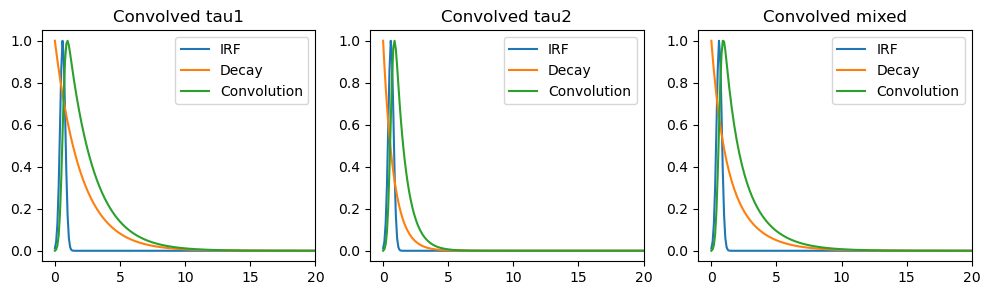

In [21]:
fig, ax = plt.subplots(1,3, figsize = (12,3))

ax[0].plot(time, syn_irf, label = "IRF")
ax[0].plot(time, normalized_counts_tau1, label = "Decay")
ax[0].plot(time, conv_counts_tau1, label = "Convolution")
ax[0].set_title('Convolved tau1')
ax[0].legend(loc="upper right")
ax[0].set_xlim((-1,x_end))


ax[1].plot(time, syn_irf, label = "IRF")
ax[1].plot(time, normalized_counts_tau2, label = "Decay")
ax[1].plot(time, conv_counts_tau2, label = "Convolution")
ax[1].set_title('Convolved tau2')
ax[1].legend(loc="upper right")
ax[1].set_xlim((-1,x_end))

ax[2].plot(time, syn_irf, label = "IRF")
ax[2].plot(time, normalized_counts_mixed, label = "Decay")
ax[2].plot(time, conv_counts_mixed, label = "Convolution")
ax[2].set_title('Convolved mixed')
ax[2].legend(loc="upper right")
ax[2].set_xlim((-1,x_end))

plt.show()

### Testing each create_synthetic_decay function command separately

In [22]:
test_tau = 1
laser_frequency = 40 # MHz
number_of_time_points = 100
sigma = 0.1
offset = 3*sigma
descaled_time = syn.create_time_array(laser_frequency,number_of_time_points)

In [23]:
ratio = int(np.rint(10000/number_of_time_points))
smooth_time_points = ratio * number_of_time_points
smooth_time = syn.create_time_array(laser_frequency, smooth_time_points)

In [24]:
smooth_decay_tau = calculate_exp(smooth_time, 1, test_tau)
smooth_irf = norm.pdf(smooth_time, loc = offset, scale = sigma)
smooth_irf /= np.max(smooth_irf)
smooth_irf = smooth_irf[smooth_irf>0]
smooth_convolved = convolve(smooth_decay_tau, smooth_irf, mode = "full", method = "direct")
descaled_convolution = np.copy(smooth_convolved[::ratio][:number_of_time_points])
descaled_convolution /=np.max(descaled_convolution)

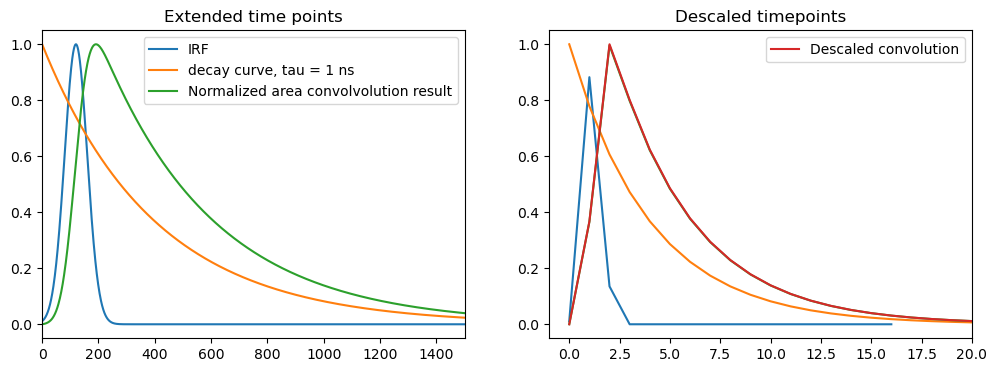

In [25]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(smooth_irf[:2000], label = "IRF")
ax[0].plot(smooth_decay_tau[:2000], label = "decay curve, tau = 1 ns")
ax[0].plot((smooth_convolved/np.max(smooth_convolved))[:2000], label = "Normalized area convolvolution result")
ax[0].set_title('Extended time points')
ax[0].legend(loc="upper right")
ax[0].set_xlim((-1,1500))


ax[1].plot(smooth_irf[::ratio])
ax[1].plot(smooth_decay_tau[::ratio])
ax[1].plot((smooth_convolved/np.max(smooth_convolved))[::ratio])
ax[1].plot(descaled_convolution, label = "Descaled convolution")
ax[1].set_title('Descaled timepoints')
ax[1].legend(loc="upper right")
ax[1].set_xlim((-1,20))

plt.show()



### Adding some noise

MATLAB code notes from this paper suggest adding noise after scaling!!!<br>
https://iopscience.iop.org/article/10.1088/2050-6120/aa8055  

``NOTE: After adding noise the simulated decay will have a peak count ``<br>
``%       slightly higher or lower than the defined value. Re-scaling after``<br>
``%       adding noise is not advised, however, as it will skew the noise``<br>
``%       distribution.``

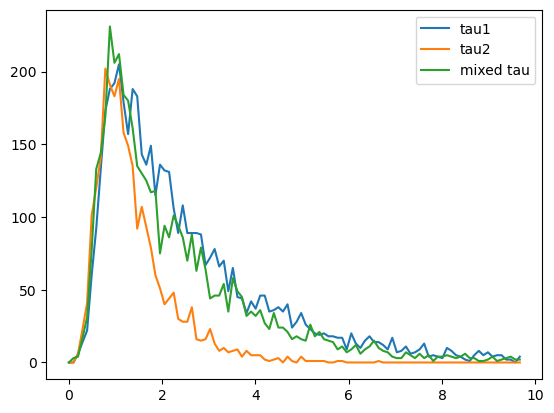

In [26]:
max_number_of_photons = 200

noisy_tau1 = np.random.poisson(max_number_of_photons * conv_counts_tau1)
noisy_tau2 = np.random.poisson(max_number_of_photons * conv_counts_tau2)
noisy_mixed_tau = np.random.poisson(max_number_of_photons * conv_counts_mixed)
# noisy_tau3 = np.random.poisson(max_number_of_photons * conv_counts_tau3)

plt.plot(time[:100], noisy_tau1[:100], label = "tau1")
plt.plot(time[:100], noisy_tau2[:100], label = "tau2")
plt.plot(time[:100], noisy_mixed_tau[:100], label = "mixed tau")
# plt.plot(time[:100], noisy_tau3[:100], label = "tau3")
plt.legend()
plt.show()


### Assigning life-times to cat masks

In [27]:
def add_lifetime_via_mask(image_size, mask, tcspc_array, max_photon_count = 2000, bg_counts = 0):
    import numpy as np

    processed_image = np.zeros((len(tcspc_array), image_size[0], image_size[1]))
    for x,y in np.transpose(mask.nonzero()):
        processed_image[:,x,y] = np.random.poisson(max_photon_count * tcspc_array) + bg_counts
    
    masked_points = processed_image[:,mask]
    return(masked_points)

In [43]:
bg = 0
max_number_of_photons = 200
time_image = bg * np.ones((len(conv_counts_tau1), copy_cat.shape[0], copy_cat.shape[1]))

# time_image[:, bright] = add_lifetime_via_mask(copy_cat.shape, bright, conv_counts_tau3, bg_counts = bg)
time_image[:, white] = add_lifetime_via_mask(copy_cat.shape, white, conv_counts_tau1, bg_counts = bg, max_photon_count = max_number_of_photons)
time_image[:, grey] = add_lifetime_via_mask(copy_cat.shape, grey, conv_counts_mixed, bg_counts = bg, max_photon_count = max_number_of_photons)
time_image[:, dark] = add_lifetime_via_mask(copy_cat.shape, dark, conv_counts_tau2, bg_counts = bg, max_photon_count = max_number_of_photons)

In [44]:
time_image = np.expand_dims(time_image, axis=[1,2])  # (ut, t, z, y, x)

In [45]:
time_image.max()

255.0

In [46]:
time_image = time_image.astype(np.uint8)

In [47]:
# from skimage.io import imsave
# imsave('lifetime_cat.tif', time_image)

In [48]:
time_image.shape

(256, 1, 1, 256, 256)

In [49]:
import yaml

In [50]:
metadata = dict(
    image_shape = (256, 1, 1, 256, 256),
    dimensions = ('photon_counts', 'time', 'z', 'y', 'x'),
    n_bins = 256,
    laser_frequency = 40,
    laser_frequency_units = 'MHz',
    lifetimes = (0.8, 2),
    lifetimes_units = 'ns',
    lifetime_to_amplitude_ratio_in_mixed_region = {0.8: 0.6, 2: 0.4},
    label_to_lifetime_mapping = {1: [0.8], 2: [0.8, 2], 3: [2]},
    max_photon_count = 255,
    IRF_function = 'gaussian',
    IRF_FWHM = 0.2,
    IRF_time_shift = 0.6,
    noise_type = 'poisson',
)

# with open('metadata.yml', 'w') as outfile:
#     yaml.safe_dump(metadata, outfile, default_flow_style=False)

In [51]:
with open("metadata.yml", "r") as stream:
    try:
        my_dict = yaml.safe_load(stream)
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

None


In [52]:
viewer = napari.Viewer()

In [53]:
viewer.add_image(time_image)

<Image layer 'time_image' at 0x1cb46ec1d60>

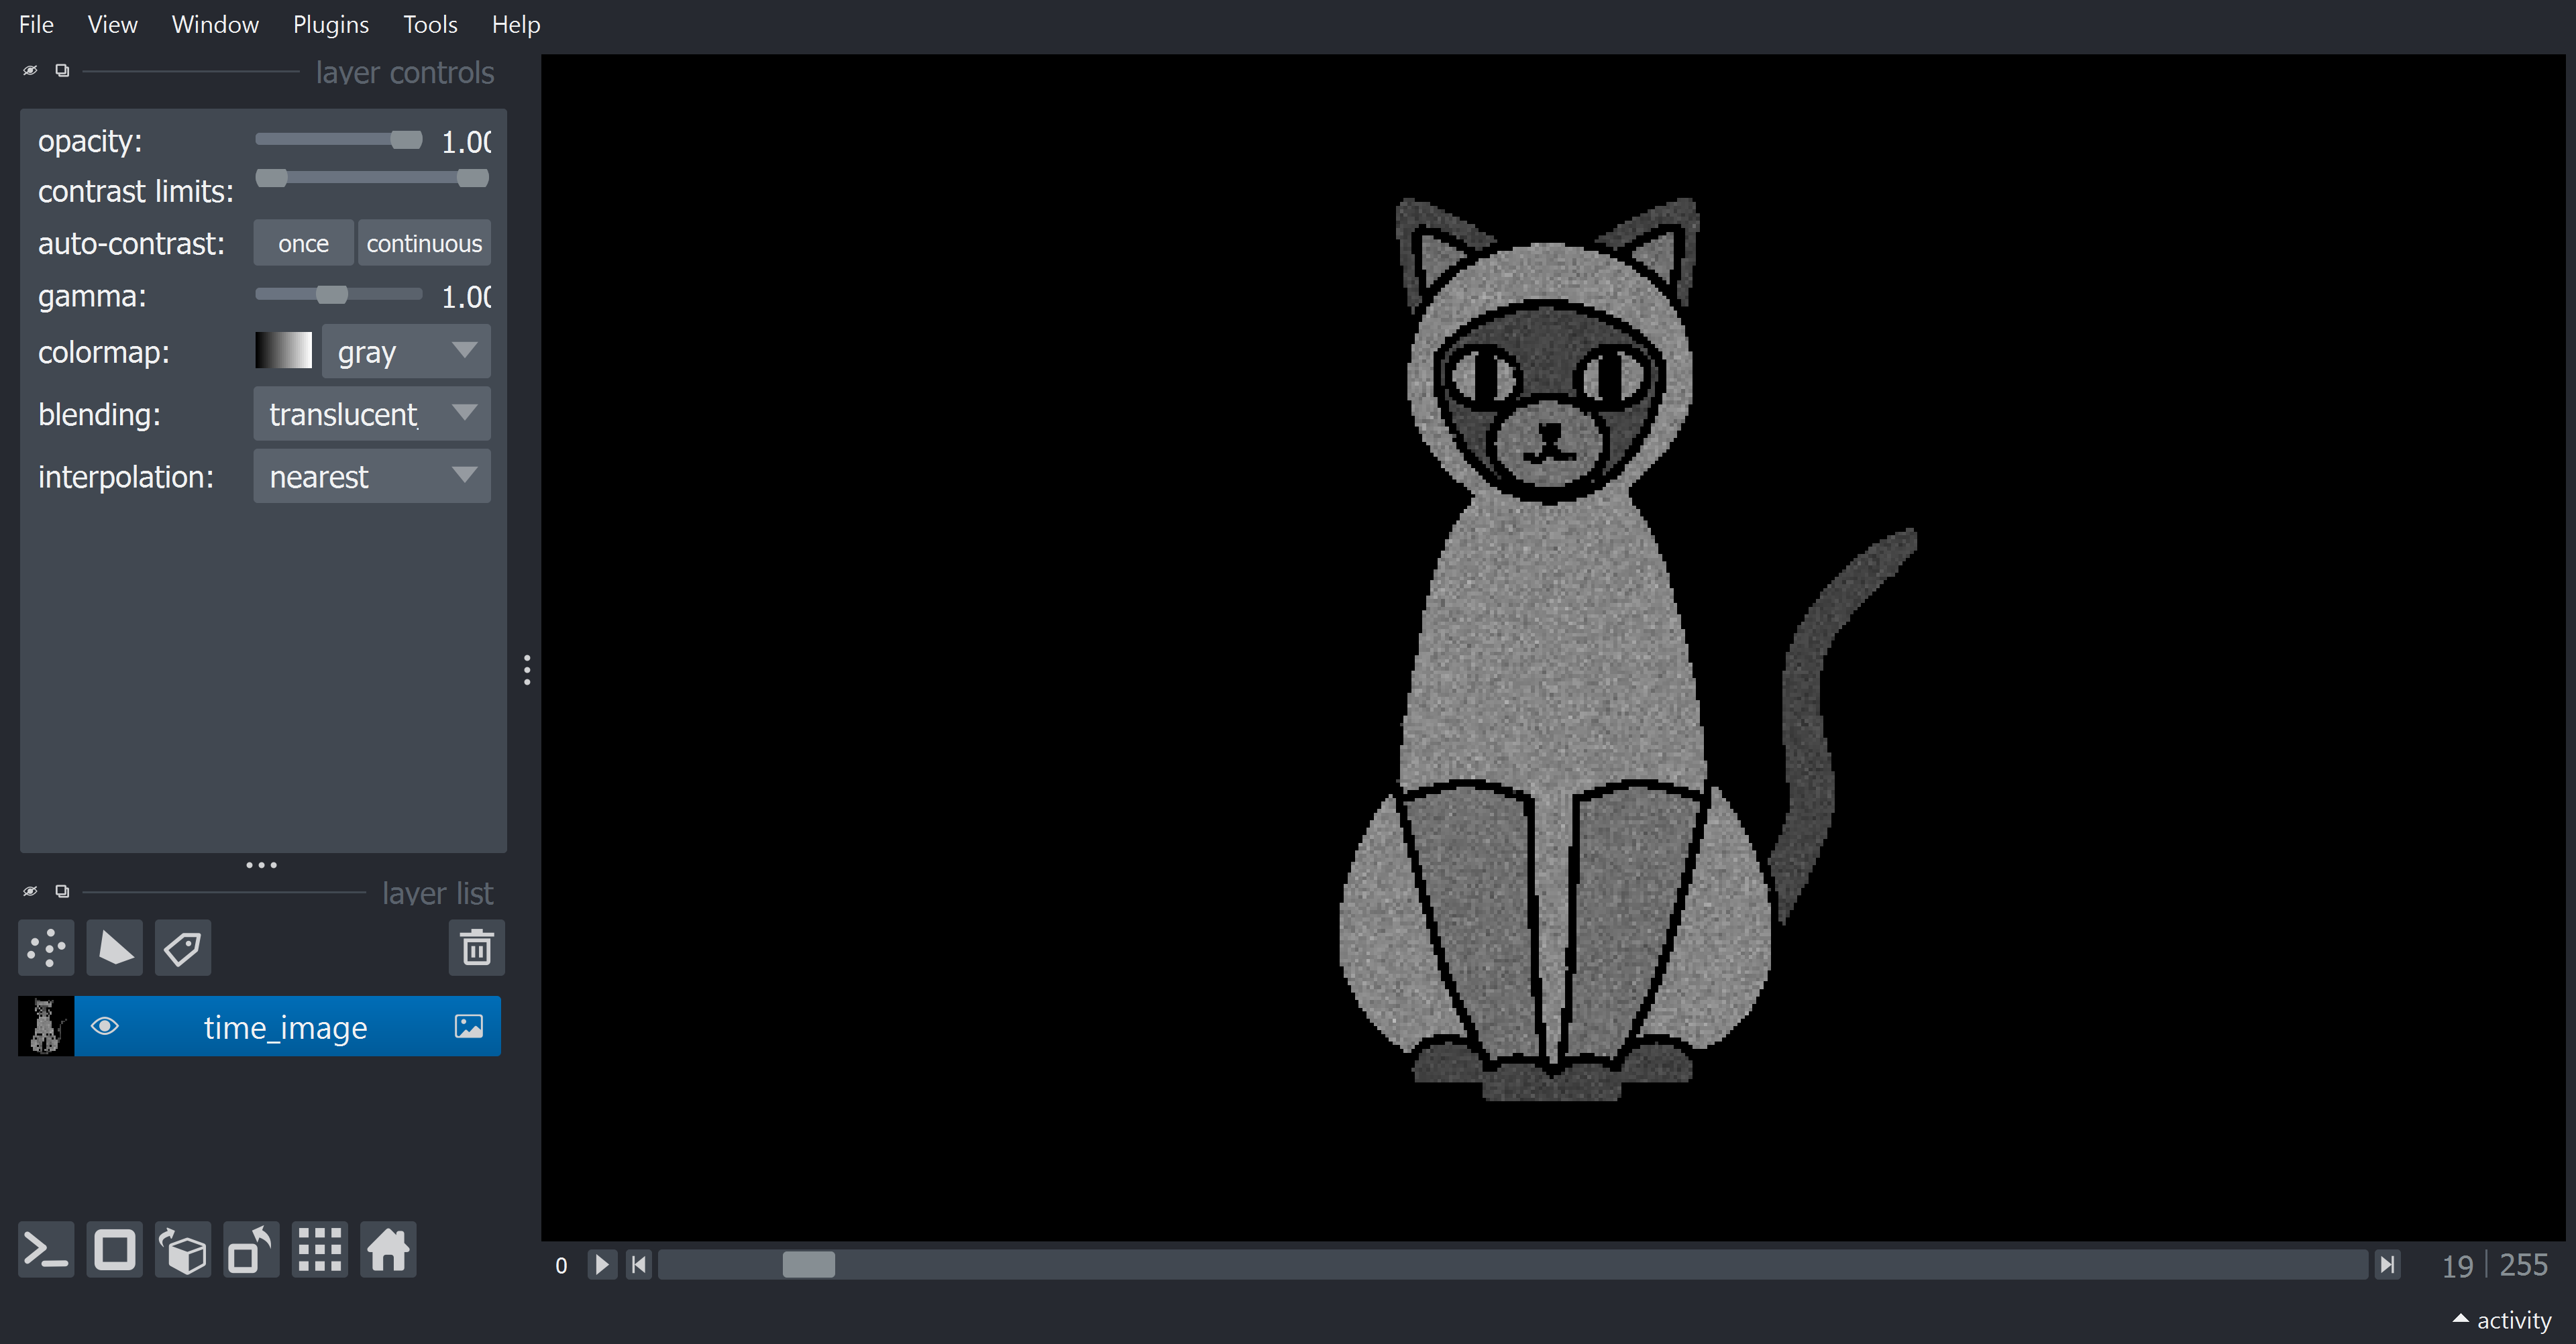

In [54]:
napari.utils.nbscreenshot(viewer)